# Goal

The goal of this notebook is to conduct topic modeling for the world of tanks blitz using both NMF algorithm and Bertopic.

In [ ]:
#NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import pandas as pd
games_reviews = pd.read_csv('Mid_DS_NLP.csv')

In [3]:
# print the ratio of duplicate reviews
print('Ratio of duplicate reviews: ', games_reviews.duplicated(subset=['review']).mean())
# print shape before dropping duplicates
print('Shape before dropping duplicates: ', games_reviews.shape)
# drop duplicates
games_reviews.drop_duplicates(subset=['review'], inplace=True)
# print the shape
print('Shape after removing duplicates: ', games_reviews.shape)

Ratio of duplicate reviews:  0.1404958490890146
Shape before dropping duplicates:  (1769732, 5)
Shape after removing duplicates:  (1521092, 5)


In [4]:
# Function to classify sentiment based on player ratings
def classify_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

# Apply sentiment analysis to the reviews
games_reviews['sentiment'] = games_reviews['rating'].apply(classify_sentiment)

In [5]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts, bigram_mod, trigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 
def lemmatization(texts, allowed_postags,nlp= nlp):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        if allowed_postags is None: 
            texts_out.append([token.lemma_ for token in doc])
        else:
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:
def preprocessing(df):
    # Convert to list
    data = df.review.values.tolist()

    # Remove Emails if any
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    data =  list(sent_to_words(data))

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data], threshold=100)  
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)


    # Form Bigrams
    data_words_bigrams = make_bigrams(data, bigram_mod)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # Do lemmatization keeping only noun, adj, vb, adv
    #data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=None)

    # remove stopwords
    data_words_nostops = remove_stopwords(data_words_bigrams)

    # # remove lemmatized words that are empty (has length =0)
    # data_lemmatized = [data for data in data_words_nostops if len(data)>0 else: ]

    return data_words_nostops

In [18]:
# selecting only the reviews for World of Tanks Blitz
wargaming_df = games_reviews[games_reviews['app_name']=='World of Tanks Blitz']

In [19]:
wargaming_df.shape

(42530, 6)

In [20]:
# processing the reviews for World of Tanks Blitz
wargaming_df['clean_review'] = preprocessing(wargaming_df)

/var/folders/tq/4lg57j0x7j394cz4rt750tsr0000gn/T/ipykernel_50626/3472312008.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wargaming_df['clean_review'] = preprocessing(wargaming_df)


In [21]:
wargaming_pos_reviews = wargaming_df[wargaming_df['sentiment']=='positive']
wargaming_neg_reviews = wargaming_df[wargaming_df['sentiment']=='negative']
wargaming_neu_reviews = wargaming_df[wargaming_df['sentiment']=='neutral']

In [28]:
wargaming_pos_reviews['clean_review']= wargaming_pos_reviews['clean_review'].apply(lambda x: ' '.join(x))
wargaming_neg_reviews['clean_review'] = wargaming_neg_reviews['clean_review'].apply(lambda x: ' '.join(x))
wargaming_neu_reviews['clean_review'] = wargaming_neu_reviews['clean_review'].apply(lambda x: ' '.join(x))


In [29]:
wargaming_pos_reviews.shape, wargaming_neg_reviews.shape, wargaming_neu_reviews.shape

((24545, 7), (13833, 7), (4152, 7))

# NMF Topic Modeling

In [310]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

In [318]:
# vetorize the pos_reviews_tank_game with tfidf
vectorizer = CountVectorizer(ngram_range=(1,1))
tfidf = vectorizer.fit_transform(wargaming_neg_reviews['clean_review'])

In [319]:
vocab = np.array(vectorizer.get_feature_names_out())

In [320]:
# Applying Non-Negative Matrix Factorization
nmf = NMF(n_components=10, solver="cd")
W = nmf.fit_transform(tfidf)
H = nmf.components_

In [321]:
for i, topic in enumerate(H):
     print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in vocab[topic.argsort()[-10:]]])))

Topic 1: dont,fun,make,years,played,like,good,bad,playing,game
Topic 2: enough,never,bad,people,wargaming,glitches,many,teams,like,players
Topic 3: tech_tree,make,better,even,new,buy,like,tier,premium,tanks
Topic 4: always,problem,unable,im,even,please,connect,fix,cant,server
Topic 5: new,also,buy,one,really,please,get,like,tier,tank
Topic 6: still,like,games,even,free,want,time,dont,cant,play
Topic 7: games,always,enemy,get,match,matchmaking,bots,player,tier,team
Topic 8: free,people,nothing,time,make,years,wargaming,spend,get,money
Topic 9: rigged,dont,even,premium,credits,get,rate,lose,pay,win
Topic 10: im,one,battle,still,since,last,every,new,time,update


# Bert Training 

In [30]:
from bertopic import BERTopic

In [51]:
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer


# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
#representation_model = KeyBERTInspired()

# Bert model for positive reviews
pos_topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  #representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic represenations
  nr_topics="auto",
  #calculate_probabilities=True,
  verbose=True
)
# bert model for negative reviews
neg_topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic represenations
  nr_topics="auto",
  #calculate_probabilities=True,
  verbose=True
)


In [36]:
# selecting non-empty reviews
neg_docs = wargaming_neg_reviews[wargaming_neg_reviews['review'].apply(lambda x: len(x)!=0)]
pos_docs = wargaming_pos_reviews[wargaming_pos_reviews['review'].apply(lambda x: len(x)!=0)]

In [172]:
wargaming_pos_reviews.shape, wargaming_neg_reviews.shape

((24545, 7), (13833, 7))

## Analysing the Positive Reviews

In [203]:
pos_topics, probs = pos_topic_model.fit_transform(wargaming_pos_reviews.review)

Batches: 100%|██████████| 768/768 [01:05<00:00, 11.75it/s]
2023-11-26 22:46:55,359 - BERTopic - Transformed documents to Embeddings
2023-11-26 22:47:01,309 - BERTopic - Reduced dimensionality
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable thi

In [56]:
# saving negative topics and topic model as pickle
import pickle
with open('bert_models/tank_pos_topics.pickle', 'wb') as f:
    pickle.dump(pos_topics, f)
with open('bert_models/tank_pos_topic_model.pickle', 'wb') as f:
    pickle.dump(pos_topic_model, f)

In [208]:
pos_topic_model.visualize_barchart(top_n_topics = 15, n_words = 10)
# some topics has non-meaningfull keywords

In [207]:
pos_topic_model.get_topic_info(-1)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,9585,-1_tanks_game_tank_like,"[tanks, game, tank, like, good, play, just, gr...",[Great game 👌 it was a lot of fun playing this...


-  the number of outliers is "9585" for the topic [-1] which is huge therefoe we will remove the outliers

In [ ]:
with open('bert_models/tank_pos_topic_model.pickle', 'rb') as f:
    pos_topic_model = pickle.load(f)
new_topics = pos_topic_model.reduce_outliers(wargaming_pos_reviews.review.values, pos_topics,strategy="c-tf-idf", threshold=0.001)
pos_topic_model.update_topics(wargaming_pos_reviews.review, topics=new_topics)
new_topics = pos_topic_model.reduce_outliers(wargaming_pos_reviews.review.values, pos_topics,strategy="c-tf-idf", threshold=0.001)
pos_topic_model.update_topics(wargaming_pos_reviews.review, topics=new_topics)

- after remving the outliers the topics became more meaningful so we can extract some insights from them

In [67]:
pos_topic_model.visualize_barchart(top_n_topics = 15, n_words = 10)

In [327]:
# Topic 1: Pleasent experience
pos_topic_model.get_topic_info(0)

,Topic,Count,Name,Representation,Representative_Docs
0,0,7906,0_tanks_best_game_tank,"[tanks, best, game, tank, good, graphics, worl...","[Best tank game in The world, Graphics its jus..."


In [328]:
# Topic 2: Problem
pos_topic_model.get_topic_info(1)

,Topic,Count,Name,Representation,Representative_Docs
0,1,407,1_connect_server_download_resources,"[connect, server, download, resources, loading...","[I can't connect to the server. Why?, This gam..."


In [329]:
# Topic 2: Chatting
pos_topic_model.get_topic_info(2)

,Topic,Count,Name,Representation,Representative_Docs
0,2,333,2_chat_platoon_voice_friends,"[chat, platoon, voice, friends, crew, add, fri...","[Just put on voice chat, I would like to have ..."


In [330]:
# Topic 3: Rating
pos_topic_model.get_topic_info(3)

,Topic,Count,Name,Representation,Representative_Docs
0,3,309,3_stars_star_rate_rating,"[stars, star, rate, rating, game, rated, ll, g...","[now i can play again.....so i give 5 stars, I..."


In [331]:
# Topic 4: Accounts
pos_topic_model.get_topic_info(5)

,Topic,Count,Name,Representation,Representative_Docs
0,5,276,5_account_login_log_password,"[account, login, log, password, email, lost, o...","[I can Login to my old account Fix it !!!!, Pl..."


In [332]:
# Topic 5: Sound
pos_topic_model.get_topic_info(7)

,Topic,Count,Name,Representation,Representative_Docs
0,7,246,7_sound_sounds_gun_old,"[sound, sounds, gun, old, new, effects, shot, ...","[I want new Sound Gun, New Gun Sound in Next U..."


In [333]:
# Topic 6: Currencies
pos_topic_model.get_topic_info(8)

,Topic,Count,Name,Representation,Representative_Docs
0,8,244,8_gold_silver_buy_coins,"[gold, silver, buy, coins, 000, store, money, ...","[The game is good but how to get gold?, Good g..."


In [334]:
# Topic 7: Controller
pos_topic_model.get_topic_info(9)

,Topic,Count,Name,Representation,Representative_Docs
0,9,220,9_controls_controller_control_joystick,"[controls, controller, control, joystick, game...","[nice game easy controls, I've been playing th..."


In [95]:
pos_topic_map = {0: 'Pleasent experience', 1: 'Problem', 2: 'Chatting', 3: 'Rating', 5: 'Accounts', 7: 'Sound', 8: 'Currencies', 9: 'Controller'}

- plotting the frequency of all top topics in the positive reviews

Text(0.5, 0, 'Count')

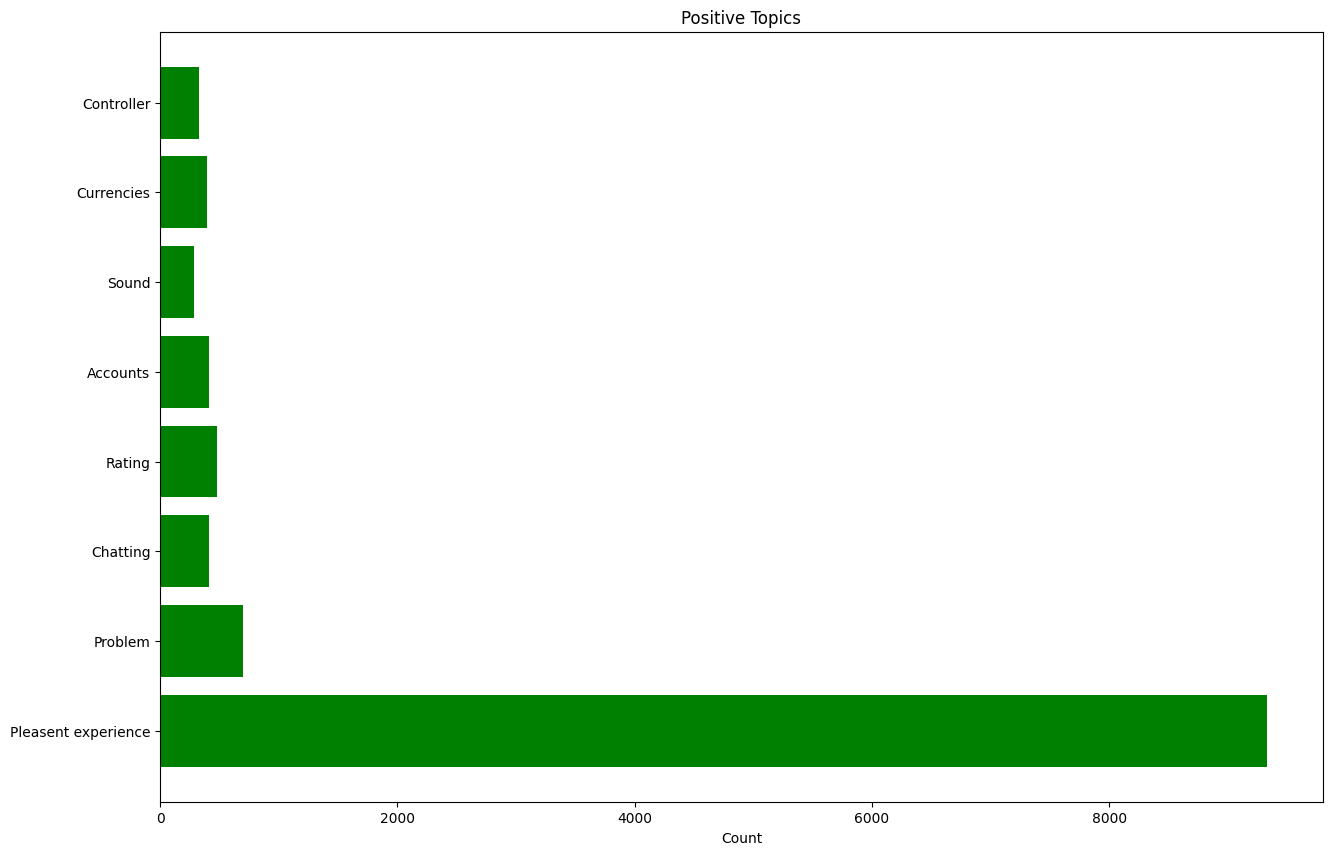

In [110]:
positive_topics = pos_topic_model.get_topic_info()
# plot x, y
plt.figure(figsize=(15, 10))
plt.barh(list(pos_topic_map.values()), positive_topics[positive_topics['Topic'].isin(pos_topic_map.keys())]['Count'], color='green')
plt.title('Positive Topics')
plt.xlabel('Count')

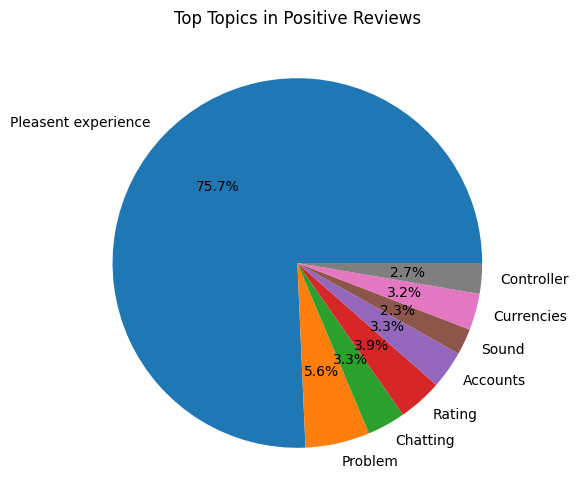

In [294]:
# plot x, y
plt.figure(figsize=(6, 6))
plt.pie(positive_topics[positive_topics['Topic'].isin(pos_topic_map.keys())]['Count'], labels=list(pos_topic_map.values()), autopct='%1.1f%%')
plt.title('Top Topics in Positive Reviews')
plt.show()

- understaing the topics over the time

In [295]:
pos_documents_with_topic = pos_topic_model.get_document_info(wargaming_pos_reviews.review)
pos_documents_with_topic['date'] = wargaming_pos_reviews['dt'].to_list()
pos_topics_over_time = pos_topic_model.topics_over_time(pos_documents_with_topic['Document'].to_list(), pos_documents_with_topic['date'].to_list(), nr_bins=6)


6it [00:00,  6.42it/s]


In [296]:
pos_topics_over_time = pos_topics_over_time[pos_topics_over_time['Topic'].isin(pos_topic_map.keys())]
pos_topics_over_time['Topic_name'] = pos_topics_over_time.apply(lambda x:pos_topic_map[x['Topic']], axis=1)

Text(0, 0.5, 'Count')

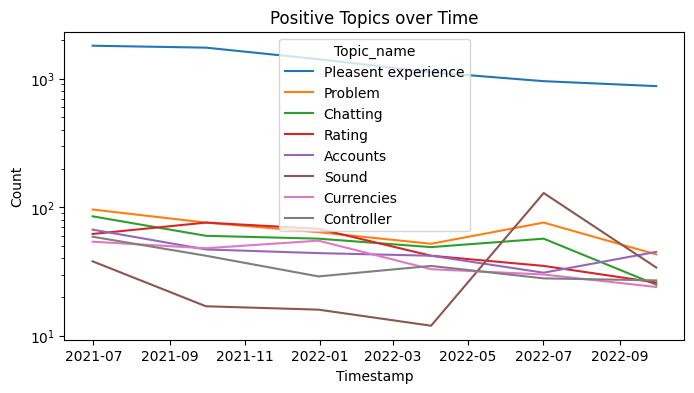

In [305]:
# plot the neg_topics_over_time base on Timesamps and Topics_name
import seaborn as sns
plt.figure(figsize=(8, 4))
sns.lineplot(data=pos_topics_over_time, x="Timestamp", y="Frequency", hue="Topic_name")
# scale y-axis
plt.yscale('log')
plt.title('Positive Topics over Time')
plt.xlabel('Timestamp')
plt.ylabel('Count')


## Analysing the Negative Reviews

In [145]:
neg_topics, probs = neg_topic_model.fit_transform(wargaming_neg_reviews.review)

Batches: 100%|██████████| 433/433 [00:46<00:00,  9.28it/s]
2023-11-26 21:52:47,853 - BERTopic - Transformed documents to Embeddings
2023-11-26 21:52:51,085 - BERTopic - Reduced dimensionality
2023-11-26 21:52:51,356 - BERTopic - Clustered reduced embeddings
2023-11-26 21:52:51,959 - BERTopic - Reduced number of topics from 116 to 63


In [146]:
# saving negative topics and topic model as pickle
import pickle
with open('bert_models/tank_neg_topics.pickle', 'wb') as f:
    pickle.dump(neg_topics, f)
with open('bert_models/tank_neg_topic_model.pickle', 'wb') as f:
    pickle.dump(neg_topic_model, f)

In [147]:
neg_topic_model.visualize_barchart(top_n_topics = 15, n_words = 10)

In [175]:
# merging some similar topics together to make the topics more meaningful
neg_topic_model.merge_topics(wargaming_neg_reviews.review, [[0,7], [10,9,12,5]])

In [176]:
neg_topic_model.visualize_barchart(top_n_topics = 15, n_words = 10)

In [ ]:
# we still we have to merge topic [0],[6] because both of them are talking about the same thing
neg_topic_model.merge_topics(wargaming_neg_reviews.review, [[0,6]])

In [250]:
neg_topic_model.visualize_barchart(top_n_topics = 15, n_words = 10)

- selecting some interesting topcis from the negative reviews topic analysis which have some meaningful insights

In [335]:
# Topic 1: Connection
neg_topic_model.get_topic_info(0)

,Topic,Count,Name,Representation,Representative_Docs
0,0,5056,0_to_it_server_the,"[to, it, server, the, game, and, can, this, is...",[Is there still many WG dogs bloating free to ...


In [336]:
# Topic 2: Money
neg_topic_model.get_topic_info(1)

,Topic,Count,Name,Representation,Representative_Docs
0,1,789,1_credits_win_money_pay,"[credits, win, money, pay, credit, you, to, pr...",[I love this game but the thing that pisses me...


In [337]:
# Topic 3: Bots   
neg_topic_model.get_topic_info(2)

,Topic,Count,Name,Representation,Representative_Docs
0,2,498,2_bots_bot_team_you,"[bots, bot, team, you, and, of, with, are, the...",[Everything is good in this game but please re...


In [338]:
# Topic 4: Russian_Ukrain
neg_topic_model.get_topic_info(3)

,Topic,Count,Name,Representation,Representative_Docs
0,3,297,3_and_of_russian_players,"[and, of, russian, players, you, ukraine, they...",[Earned 11million free XP over the years. IN G...


In [339]:
# Topic 5: Offensive
neg_topic_model.get_topic_info(4)

,Topic,Count,Name,Representation,Representative_Docs
0,4,260,4_toxic_players_banned_and,"[toxic, players, banned, and, you, report, ban...",[This game’s online community is infamously to...


In [340]:
# Topic 6: Control
neg_topic_model.get_topic_info(5)

,Topic,Count,Name,Representation,Representative_Docs
0,5,254,5_controls_control_button_controller,"[controls, control, button, controller, the, i...","[Worst game controls, Worst game.... The contr..."


In [341]:
# Topic 7: Updates
neg_topic_model.get_topic_info(10)


,Topic,Count,Name,Representation,Representative_Docs
0,10,208,10_updates_update_updating_it,"[updates, update, updating, it, the, game, to,...","[Too many Updates, So many updates!, So many u..."


In [342]:
# Topic 8: Loading
neg_topic_model.get_topic_info(12)

,Topic,Count,Name,Representation,Representative_Docs
0,12,197,12_battle_the_loading_screen,"[battle, the, loading, screen, takes, it, afte...",[Wargaming I have a problem with my wotb the p...


In [264]:
neg_topic_map = {0: 'Connection', 1: 'Money', 2: 'Bots', 3: 'Russian_Ukrain', 4: 'Offensive', 5: 'Control', 10: 'Updates', 12: 'Loading'}

- plotting the frequency of major top topics extracted from negative reviews

Text(0.5, 0, 'Count')

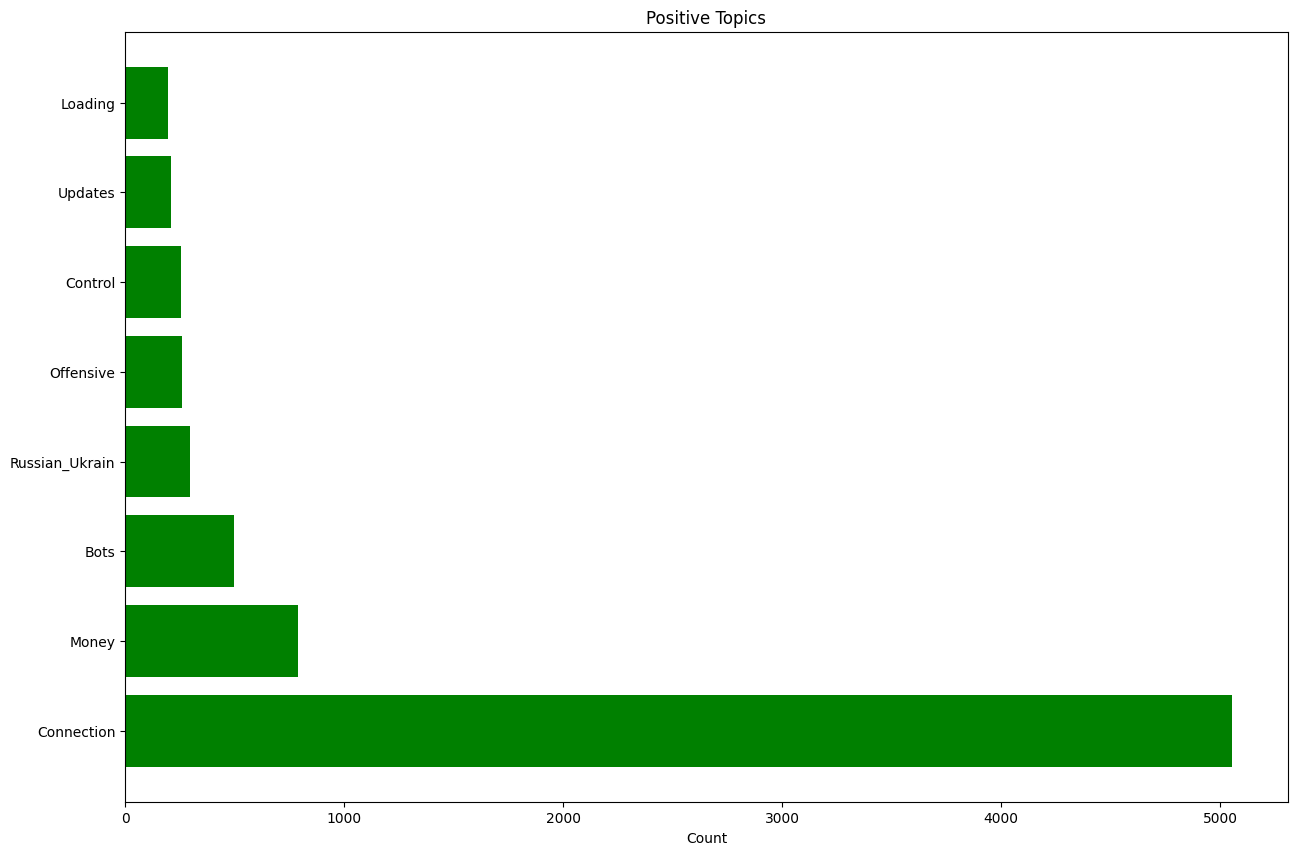

In [265]:
negative_topics = neg_topic_model.get_topic_info()
# plot x, y
plt.figure(figsize=(15, 10))
plt.barh(list(neg_topic_map.values()), negative_topics[negative_topics['Topic'].isin(neg_topic_map.keys())]['Count'], color='green')
plt.title('Positive Topics')
plt.xlabel('Count')


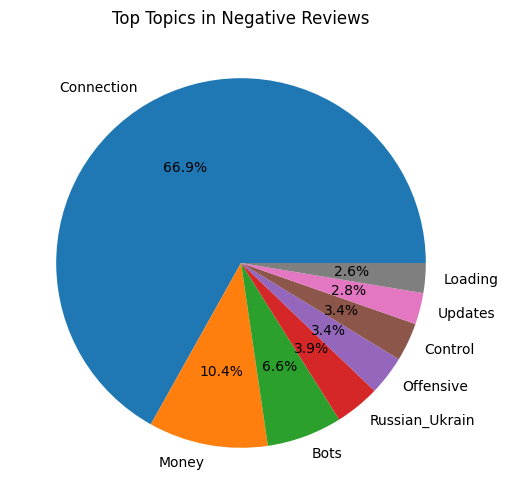

In [306]:
# plot x, y
plt.figure(figsize=(6, 6))
plt.pie(negative_topics[negative_topics['Topic'].isin(neg_topic_map.keys())]['Count'], labels=list(neg_topic_map.values()), autopct='%1.1f%%')
plt.title('Top Topics in Negative Reviews')
plt.show()

- analysing the topcis over the time to define the trends

In [274]:
neg_documents_with_topic = neg_topic_model.get_document_info(wargaming_neg_reviews.review)
neg_documents_with_topic['date'] = wargaming_neg_reviews['dt'].to_list()
neg_topics_over_time = neg_topic_model.topics_over_time(neg_documents_with_topic['Document'].to_list(), neg_documents_with_topic['date'].to_list(), nr_bins=6)

6it [00:00,  8.46it/s]


In [275]:
neg_topics_over_time = neg_topics_over_time[neg_topics_over_time['Topic'].isin(neg_topic_map.keys())]
neg_topics_over_time['Topic_name'] = neg_topics_over_time.apply(lambda x:neg_topic_map[x['Topic']], axis=1)

Text(0, 0.5, 'Count')

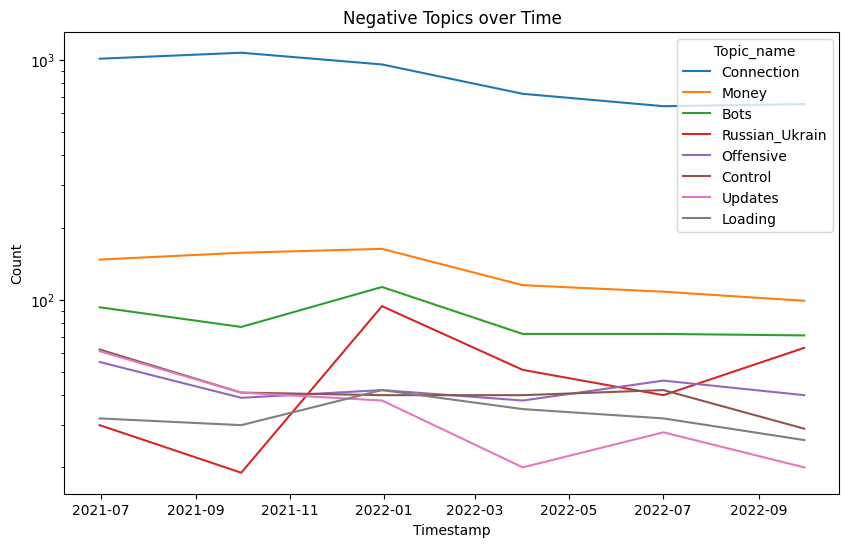

In [279]:
# plot the neg_topics_over_time base on Timesamps and Topics_name
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.lineplot(data=neg_topics_over_time, x="Timestamp", y="Frequency", hue="Topic_name")
# scale y-axis
plt.yscale('log')
plt.title('Negative Topics over Time')
plt.xlabel('Timestamp')
plt.ylabel('Count')
